In [54]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import mysql.connector as conn
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

import re
import json
import glob
import warnings
warnings.filterwarnings('ignore')

In [3]:
username = None
password = None

with open("../connection.json") as connection_file:
    cf = json.load(connection_file)
    username = cf["user"]
    password = cf["password"]

cnx = conn.connect(
    host="localhost",
    database="foodaps",
    user=username,
    password=password,
)

In [4]:
AME_QUERY_FILE = "../sql/ame.sql"
ENU_QUERY_FILE = "../sql/enu.sql"
INDIV_CHAR_QUERY_FILE = "../sql/indiv_char.sql"
HOUSEHOLD_CHAR_QUERY_FILE = "../sql/household_char.sql"
FAH_NUTRIENTS_QUERY_FILE = "../sql/fah_nutrients.sql"

enu_weights = {
    "breakfast": 0.16, 
    "lunch": 0.43, 
    "dinner": 0.30, 
    "snack": 0.11
}

def get_query(conn, query_file): 
    """
    Given a query and a connection returns a pandas table. 
    """
    with open(query_file, "r") as f:
        query = f.read()
    return pd.read_sql(query, conn)

def create_enu_table(): 
    """
    Creates a table from two queries to calculate the 
    equivalent nutritional units (ENU) for each person in the
    houshold and aggregates it to the household level. Does 
    not account for guests. 
    """
    ame = get_query(cnx, AME_QUERY_FILE)
    enu = get_query(cnx, ENU_QUERY_FILE)

    enu["tot_snacks"] = enu["tot_snackam"] + enu["tot_snackpm"]
    enu["weekly_enu"] = (enu["tot_brkfst"]*enu_weights["breakfast"] 
        + enu["tot_lunch"]*enu_weights["lunch"] 
        + enu["tot_dinner"]*enu_weights["dinner"] 
        + enu["tot_snacks"]*enu_weights["snack"])

    return ame.merge(enu, left_on=["HHNUM", "PNUM"], right_on=["HHNUM", "PNUM"], how="left").groupby(
        "HHNUM").agg({
            "weekly_enu": "sum",
            "TEE": "sum", 
            "AME": "sum"
        }).reset_index()

def majority_vote_household_demographic(hh_series):
    """
    If a household comprises of members of the same 
    race, then returns that race. Otherwise, returns
    "mixed".
    """
    if hh_series.unique().shape[0] == 1:
        return hh_series.unique()[0]
    else:
        return "mixed"

def create_household_table():
    """
    Creates a table from two queries to create household
    characteristics for explanatory analysis. 
    """
    indiv = get_query(cnx, INDIV_CHAR_QUERY_FILE)
    hh = get_query(cnx, HOUSEHOLD_CHAR_QUERY_FILE)

    hh["guest_enu"] = (hh["nguest_brkfst"] * enu_weights["breakfast"] + 
        hh["nguest_lunch"] * enu_weights["lunch"] + 
        hh["nguest_dinner"] * enu_weights["dinner"] + 
        hh["nguest_snack"] * enu_weights["snack"])

    hh_demo = indiv.groupby("hhnum").agg({
        "Race": majority_vote_household_demographic,
        "Hispanic": majority_vote_household_demographic,
        "female_head": "first"}).reset_index()

    return hh.merge(hh_demo, left_on="hhnum", right_on="hhnum", how="left")

def create_nutrients_table(): 
    """
    Creates a table from a query for weekly nutrition by household. 
    """
    fah_nut = get_query(cnx, FAH_NUTRIENTS_QUERY_FILE)
    fah_nut = fah_nut.dropna()

    #remove SUM() and hh_ from column names
    fah_nut.columns = [col.split("_")[1] if "SUM" in col else col for col in fah_nut.columns]

    #remove ) from column names
    fah_nut.columns = [col.split(")")[0] if ")" in col else col for col in fah_nut.columns]

    #add fah to column_names except for hhnum
    fah_nut.columns = ["fah_" + col if col != "hhnum" else col for col in fah_nut.columns]

    return fah_nut

def create_dataset(): 
    enu = create_enu_table()
    hh = create_household_table()
    nut = create_nutrients_table()
    snap = nut.merge(enu, left_on="hhnum", right_on="HHNUM", how="left").merge(
    hh, left_on="hhnum", right_on="hhnum", how="left")

    return snap

def prepare_data():
    snap = create_dataset()
    snap["total_enus"] = snap["weekly_enu"] + snap["guest_enu"]
    snap["total_enus"] = snap["total_enus"] * snap["AME"]

    # drop rows with total_enu == 0, meaning no meals at home were eaten
    snap = snap[snap["total_enus"] != 0]

    # engineer explanatory variables
    snap["household_recieves_snap"] = (snap["snapnowhh"] > 0).astype("int")
    snap["household_weekly_snap_benefits"] = snap["SNAPLASTAMT"]/snap["AME"]
    snap["household_weekly_money_income"] = snap["inchhavg_r"]/snap["AME"]
    snap["household_weekly_money_income_squared"] = snap["household_weekly_money_income"]**2
    snap["school_breakfast"] = (snap["schservebrkfst"] > 0).astype("int")
    snap["houshold_recieves_wic"] = (snap["wichh"] > 0).astype("int")
    snap["female_head_present"] = (snap["female_head"])
    snap["black"] = (snap.Race == "Black").astype("int")
    snap["hispanic"] = (snap.Hispanic == "Hispanic").astype("int")
    snap["guest_meals"] = snap["guest_enu"] / snap["AME"]
    return snap 

In [5]:
snap = prepare_data()

explanatory_vars_mpc = [
    "household_weekly_snap_benefits",
    "household_weekly_money_income",
    "household_weekly_money_income_squared",
    "school_breakfast",
    "houshold_recieves_wic",
    "female_head_present",
    "black",
    "hispanic",
    "midwest",
    "south", 
    "west",
    "guest_meals",
    "nonmetro"
]

explanatory_vars_binary = [
    "household_recieves_snap",
    "household_weekly_money_income",
    "household_weekly_money_income_squared",
    "school_breakfast",
    "houshold_recieves_wic",
    "female_head_present",
    "black",
    "hispanic",
    "midwest",
    "south", 
    "west",
    "guest_meals",
    "nonmetro"
]

response_vars = [
    nut_var for nut_var in snap.columns if re.match(r"fah_*", nut_var)
]

In [7]:
## dataset restriction 1 - target group 1 & 4
restriction_1 = snap[snap["targetgroup"].isin([1,4])]

## dataset restriction 2 - target group 1, 2, & 4
restriction_2 = snap[snap["targetgroup"].isin([1,2,4])]

## dataset restriction 3 - target group 2 & 4
restriction_3 = snap[snap["targetgroup"].isin([2,4])]

def star_rating(p_value):
    """
    Using bonferroni correction, returns a star rating for the p-value. 
    """
    if p_value < 0.001/len(response_vars):
        return "∗∗∗"
    elif p_value < 0.01/len(response_vars):
        return "∗∗"
    elif p_value < 0.05/len(response_vars):
        return "∗"
    else:
        return ""

def run_results(explanatory_vars, response_vars, restricted_dataset):
    ## run through regression for each nutrient and save results to a log file
    snap_var = explanatory_vars[0]
    X = restricted_dataset[explanatory_vars]
    X = sm.add_constant(X)

    regs = {}

    for nut_var in response_vars:
        y = restricted_dataset[nut_var]/restricted_dataset["AME"]
        model = sm.OLS(y, X).fit(cov_type="HC2")

        # print out the response variable the coefficent for the household_weekly_snap_benefits variable
        # the standard error, and the p-value for the household_recieves_snap variable, if the 
        # p-value is less than 0.05 print one star, if less than 0.01 print two stars, if less than
        # 0.001 print three stars

        print(f"{nut_var} \t {model.params[snap_var]:.4f}"
            f"({model.bse[snap_var]:.4f})  \t" 
            f"{model.pvalues[snap_var]:.5f}"
            f"{star_rating(model.pvalues[snap_var])}")
        
        regs[nut_var] = model
    
    return regs

print(restriction_1.shape)
restriction_1_res = run_results(explanatory_vars_mpc, response_vars, restriction_1)

(1527, 59)
fah_energy 	 22.8739(6.2684)  	0.00026∗∗
fah_carb 	 2.9461(0.8260)  	0.00036∗∗
fah_dietfiber 	 0.0813(0.0402)  	0.04303
fah_totsug 	 1.6653(0.4382)  	0.00014∗∗
fah_totfat 	 0.9418(0.2978)  	0.00156∗
fah_satfat 	 0.3406(0.0966)  	0.00042∗∗
fah_monofat 	 0.3299(0.1122)  	0.00329
fah_polyfat 	 0.1928(0.0853)  	0.02388
fah_protein 	 0.7383(0.2065)  	0.00035∗∗
fah_chol 	 3.0143(0.8947)  	0.00075∗
fah_sodium 	 34.6854(23.3137)  	0.13681
fah_vitarae 	 5.5131(2.2494)  	0.01425
fah_vitb6 	 0.0126(0.0059)  	0.03387
fah_vitb12 	 0.0649(0.0218)  	0.00288
fah_vitc 	 0.5099(0.2033)  	0.01215
fah_iron 	 0.1265(0.0501)  	0.01156
fah_thiamin 	 0.0123(0.0051)  	0.01637
fah_riboflavin 	 0.0185(0.0058)  	0.00145∗
fah_calcium 	 10.5989(3.0741)  	0.00057∗
fah_phosphorus 	 13.7318(3.9435)  	0.00050∗
fah_magnes 	 2.2126(0.6733)  	0.00102∗


In [40]:
print(restriction_2.shape)
restriction_2_res = run_results(explanatory_vars_mpc, response_vars, restriction_2)

(2234, 59)
fah_energy 	 21.3486(5.4147)  	0.00008∗∗
fah_carb 	 2.6242(0.7060)  	0.00020∗∗
fah_dietfiber 	 0.0567(0.0355)  	0.10959
fah_totsug 	 1.5523(0.3743)  	0.00003∗∗∗
fah_totfat 	 0.9048(0.2613)  	0.00054∗
fah_satfat 	 0.3102(0.0809)  	0.00013∗∗
fah_monofat 	 0.3335(0.0985)  	0.00071∗
fah_polyfat 	 0.1850(0.0794)  	0.01986
fah_protein 	 0.6903(0.1794)  	0.00012∗∗
fah_chol 	 2.8034(0.8025)  	0.00048∗
fah_sodium 	 40.9713(18.8170)  	0.02945
fah_vitarae 	 6.0652(2.2681)  	0.00749
fah_vitb6 	 0.0139(0.0050)  	0.00548
fah_vitb12 	 0.0713(0.0215)  	0.00089∗
fah_vitc 	 0.3905(0.1797)  	0.02978
fah_iron 	 0.1117(0.0424)  	0.00848
fah_thiamin 	 0.0110(0.0043)  	0.01031
fah_riboflavin 	 0.0171(0.0049)  	0.00050∗
fah_calcium 	 9.0821(2.5836)  	0.00044∗∗
fah_phosphorus 	 12.1350(3.3390)  	0.00028∗∗
fah_magnes 	 1.7997(0.5931)  	0.00241


In [39]:
print(restriction_3.shape)
restriction_3_res = run_results(explanatory_vars_mpc, response_vars, restriction_3)

(1975, 59)
fah_energy 	 24.3356(5.8393)  	0.00003∗∗∗
fah_carb 	 2.9870(0.7602)  	0.00009∗∗
fah_dietfiber 	 0.0728(0.0386)  	0.05914
fah_totsug 	 1.7679(0.3972)  	0.00001∗∗∗
fah_totfat 	 1.0416(0.2847)  	0.00025∗∗
fah_satfat 	 0.3525(0.0864)  	0.00004∗∗∗
fah_monofat 	 0.3963(0.1072)  	0.00022∗∗
fah_polyfat 	 0.2087(0.0892)  	0.01924
fah_protein 	 0.7429(0.1907)  	0.00010∗∗
fah_chol 	 3.0195(0.8607)  	0.00045∗∗
fah_sodium 	 42.2878(20.0170)  	0.03464
fah_vitarae 	 7.1458(2.4781)  	0.00393
fah_vitb6 	 0.0152(0.0054)  	0.00448
fah_vitb12 	 0.0741(0.0232)  	0.00139∗
fah_vitc 	 0.5122(0.1933)  	0.00807
fah_iron 	 0.1274(0.0465)  	0.00611
fah_thiamin 	 0.0125(0.0047)  	0.00755
fah_riboflavin 	 0.0190(0.0053)  	0.00036∗∗
fah_calcium 	 10.2865(2.7748)  	0.00021∗∗
fah_phosphorus 	 13.2601(3.5859)  	0.00022∗∗
fah_magnes 	 2.0882(0.6349)  	0.00101∗


In [67]:
# Create a dictionary with the variable names, coefficients, and standard errors
var_dict = {
"fah_energy":"Energy (kCal)",
"fah_carb":"Carbs (g)",
"fah_dietfiber":"Dietary Fiber (g)",
"fah_totsug":"Total Sugar (g)",
"fah_totfat":"Total Fat (g)",
"fah_satfat":"Saturated Fat (g)",
"fah_monofat":"Monounsaturated Fat (g)",
"fah_polyfat":"Polyunsaturated Fat (g)",
"fah_protein":"Protein (g)",
"fah_chol":"Cholesterol (mg)",
"fah_sodium":"Sodium (mg)",
"fah_vitarae":"Vitamin A (mcg)",
"fah_vitb6":"Vitamin B¬6 (mg)",
"fah_vitb12":"Vitamin B12 (mcg)",
"fah_vitc":"Vitamin C (mg)",
"fah_iron":"Iron (mg)",
"fah_thiamin":"Thiamin (mg)",
"fah_riboflavin":"Riboflavin (mg)",
"fah_calcium":"Calcium (mg)",
"fah_phosphorus":"Phosphorus (mg)",
"fah_magnes":"Magnesium (mg)",
}

endo_dict = {
    "const": "Constant",
    "household_weekly_snap_benefits": "MPC SNAP",
    "household_weekly_money_income": "Income",
    "household_weekly_money_income_squared": "Income^2",
    "school_breakfast": "School Breakfast",
    "houshold_recieves_wic": "WIC",
    "female_head_present": "Female Head",
    "black": "Black",
    "hispanic": "Hispanic",
    "midwest": "Midwest",
    "south": "South",
    "west": "West",
    "guest_meals": "Guest Meals",
    "nonmetro": "Non-Metro"
}

macro = ["fah_energy", 
    "fah_carb", 
    "fah_dietfiber", 
    "fah_totsug",
    "fah_totfat", 
    "fah_satfat", 
    "fah_monofat", 
    "fah_polyfat", 
    "fah_protein", 
    "fah_sodium", 
]

micro = [
    "fah_chol", 
    "fah_vitarae", 
    "fah_vitb6",
    "fah_vitb12", 
    "fah_vitc", 
    "fah_iron", 
    "fah_thiamin", 
    "fah_riboflavin", 
    "fah_calcium", 
    "fah_phosphorus", 
    "fah_magnes"
]

pd.options.display.float_format = '{:.4g}'.format

def create_reg_tables(variables, regressions):
    ## create regression tables
    macro_dict = {}
    for nut in variables: 
        model = regressions[nut]
        index = model.params.index
        coefs = model.params.values
        se = model.bse.values
        stars = [star_rating(p) for p in model.pvalues.values]
        macro_dict[nut] = [f"{c:,.4g}{star}" + """
"""
        + f"({s:,.4g})" for c, s, star in zip(coefs, se, stars)]

    macro_frame = pd.DataFrame(macro_dict)
    macro_frame.index = index
    macro_frame.index = [endo_dict[ind] for ind in macro_frame.index]
    macro_frame.columns = [var_dict[col] for col in macro_frame.columns]
    return macro_frame

for var_set, vars in zip(["macro", "micro"],[macro, micro]):
    for reg_name, regs in zip(["res1", "res2", "res3"], [restriction_1_res, restriction_2_res, restriction_3_res]):
        name = f"{var_set}{reg_name}"
        df = create_reg_tables(vars, regs)
        df.to_csv(f"../{name}.csv")

In [68]:
create_reg_tables(micro, restriction_1_res)

,Cholesterol (mg),Vitamin A (mcg),Vitamin B¬6 (mg),Vitamin B12 (mcg),Vitamin C (mg),Iron (mg),Thiamin (mg),Riboflavin (mg),Calcium (mg),Phosphorus (mg),Magnesium (mg)
Constant,"1,185∗\n(373.6)","4,625∗∗∗\n(919.1)",12.8∗∗∗\n(2.453),35.49∗∗∗\n(7.945),491∗∗∗\n(110.2),96.74∗∗∗\n(21.82),10.58∗∗∗\n(2.134),11.81∗∗∗\n(2.19),"6,097∗∗∗\n(1,123)","8,061∗∗∗\n(1,446)","2,063∗∗∗\n(297.7)"
MPC SNAP,3.014∗\n(0.8947),5.513\n(2.249),0.01259\n(0.005933),0.06494\n(0.02179),0.5099\n(0.2033),0.1265\n(0.05009),0.01226\n(0.005106),0.01852∗\n(0.005815),10.6∗\n(3.074),13.73∗\n(3.944),2.213∗\n(0.6733)
Income,0.2975\n(0.1832),0.9629\n(0.4247),0.00274\n(0.001009),0.006204\n(0.002992),0.113\n(0.04524),0.02733\n(0.009447),0.002469∗\n(0.0007858),0.002935∗\n(0.0009106),1.242\n(0.482),1.458\n(0.634),0.337\n(0.1233)
Income^2,-1.181e-05\n(2.381e-05),-3.613e-05\n(6.363e-05),-1.823e-07\n(8.996e-08),-4.32e-07\n(2.661e-07),-4.841e-06\n(5.518e-06),-1.471e-06\n(1.034e-06),-1.85e-07\n(6.429e-08),-1.698e-07\n(1.004e-07),-6.128e-05\n(6.191e-05),-7.009e-05\n(8.735e-05),-1.703e-05\n(1.451e-05)
School Breakfast,-835.5∗∗∗\n(170.9),"-2,321∗∗∗\n(421.1)",-5.514∗∗∗\n(1.342),-16.01∗∗\n(4.45),-264.1∗∗∗\n(54.44),-43.64∗∗\n(11.42),-4.113∗∗\n(1.132),-4.705∗∗∗\n(1.144),"-2,948∗∗∗\n(582.1)","-3,973∗∗∗\n(758.1)",-931.4∗∗∗\n(153.6)
WIC,-51.38\n(201.3),188.8\n(547.9),1.368\n(1.686),2.943\n(5.108),95.31\n(69.64),26.93\n(16),1.808\n(1.569),2.66\n(1.591),"1,145\n(767.1)",974.1\n(999.4),-93.55\n(188.6)
Female Head,304.6\n(235.4),"1,375\n(627.8)",2.886\n(1.732),5.519\n(6.015),105.2\n(65.74),26.53\n(13.54),2.896\n(1.258),2.708\n(1.331),"1,486\n(703.5)","2,186\n(864.4)",493.1\n(181.6)
Black,-475.5\n(242.9),"-2,053∗\n(609.4)",-4.147\n(1.706),-12.83\n(5.585),-45.93\n(79.28),-23.52\n(14.52),-2.865\n(1.418),-5.648∗∗\n(1.429),"-3,243∗∗∗\n(772.8)","-4,164∗∗∗\n(969.1)",-956.2∗∗∗\n(187.1)
Hispanic,154.5\n(231.6),"-1,230\n(485.2)",-0.3727\n(1.617),-6.35\n(4.741),204.3\n(73.63),-5.277\n(14.96),-0.315\n(1.408),-1.523\n(1.354),"-1,426\n(600.8)","-1,470\n(801.5)",-207.2\n(185.1)
Midwest,737.6\n(333.9),"1,234\n(918.9)",3.803\n(2.383),15.56\n(8.36),-19.69\n(96.05),25.89\n(19.61),2.745\n(1.992),4.269\n(2.116),"3,066\n(1,167)","3,758\n(1,451)",251\n(295.2)


In [32]:
for col_name in index: 
    print(f'"{col_name}",')

"const",
"household_weekly_snap_benefits",
"household_weekly_money_income",
"household_weekly_money_income_squared",
"school_breakfast",
"houshold_recieves_wic",
"female_head_present",
"black",
"hispanic",
"midwest",
"south",
"west",
"guest_meals",
"nonmetro",


In [73]:
# Create a dictionary with the variable names, coefficients, and standard errors
var_dict = {
"fah_energy":"Energy (kCal)",
"fah_carb":"Carbs (g)",
"fah_dietfiber":"Dietary Fiber (g)",
"fah_totsug":"Total Sugar (g)",
"fah_totfat":"Total Fat (g)",
"fah_satfat":"Saturated Fat (g)",
"fah_monofat":"Monounsaturated Fat (g)",
"fah_polyfat":"Polyunsaturated Fat (g)",
"fah_protein":"Protein (g)",
"fah_chol":"Cholesterol (mg)",
"fah_sodium":"Sodium (mg)",
"fah_vitarae":"Vitamin A (mcg)",
"fah_vitb6":"Vitamin B¬6 (mg)",
"fah_vitb12":"Vitamin B12 (mcg)",
"fah_vitc":"Vitamin C (mg)",
"fah_iron":"Iron (mg)",
"fah_thiamin":"Thiamin (mg)",
"fah_riboflavin":"Riboflavin (mg)",
"fah_calcium":"Calcium (mg)",
"fah_phosphorus":"Phosphorus (mg)",
"fah_magnes":"Magnesium (mg)",
}

data = {
    "Variable": ['fah_energy', 
        'fah_carb', 'fah_dietfiber', 'fah_totsug', 'fah_totfat',
        'fah_satfat', 'fah_monofat', 'fah_polyfat', 'fah_protein',
        'fah_chol', 'fah_sodium', 'fah_vitarae', 'fah_vitb6', 
        'fah_vitb12', 'fah_vitc', 'fah_iron', 'fah_thiamin',
        'fah_riboflavin', 'fah_calcium', 'fah_phosphorus', 'fah_magnes'],
    "Coefficient": [24.3356, 2.9870, 0.0728, 1.7679, 1.0416,
        0.3525, 0.3963, 0.2087, 0.7429,
        3.0195, 42.2878, 7.1458, 0.0152, 
        0.0741, 0.5122, 0.1274, 0.0125, 
        0.0190, 10.2865, 13.2601, 2.0882],
    "Standard Error": [5.8393, 0.7602, 0.0386, 0.3972,
        0.2847, 0.0864, 0.1072, 0.0892, 
        0.1907, 0.8607, 20.0170, 2.4781, 
        0.0054, 0.0232, 0.1933, 0.0465, 0.0047, 
        0.0053, 2.7748, 3.5859, 0.6349],
    "RDA_male": [2400, 130, 34, 60, 90, 25, 32.5, 32.5,
        56, 300, 2300, 900, 1.3, 2.4, 90, 8, 1.2, 1.3,
        1000, 700, 400],
    "RDA_female": [2000, 130, 28, 50, 78, 22, 28, 28, 46,
        300, 2300, 700, 1.3, 2.4, 75, 18, 1.1, 1.1,
        1000, 700, 310],
    "P-value": [0.00003, 0.00009, 0.05914, 0.00001, 0.00025, 0.00004, 
        0.00022, 0.01924, 0.00010, 0.00045, 0.03464, 0.00393, 
        0.00448, 0.00139, 0.00807, 0.00611, 0.00755, 0.00036,
        0.00021, 0.00022, 0.00101]

}

df = pd.DataFrame(data)

## calcuate the 95% confidence interval for each coefficient
## store the lower and upper bounds in a new column
df["Lower"] = df["Coefficient"] - 1.96 * df["Standard Error"]
df["Upper"] = df["Coefficient"] + 1.96 * df["Standard Error"]

## calculate coefficients as a perecent of male and female RDA
## name the variables Lower_RDA_[fe]male, coef_RDA_[fe]male, Upper_RDA_[fe]male 

df["Lower_RDA_male"] = df['Lower']/df["RDA_male"]*100
df["coef_RDA_male"] = df["Coefficient"]/df["RDA_male"]*100
df["Upper_RDA_male"] = df["Upper"]/df["RDA_male"]*100

df["Lower_RDA_female"] = df['Lower']/df["RDA_female"]*100
df["coef_RDA_female"] = df["Coefficient"]/df["RDA_female"]*100
df["Upper_RDA_female"] = df["Upper"]/df["RDA_female"]*100

df['var_name'] = df['Variable'].map(var_dict)
df["stars"] = df.apply(lambda x: star_rating(x["P-value"]), axis=1)
df.to_csv("../../out/rda.csv")

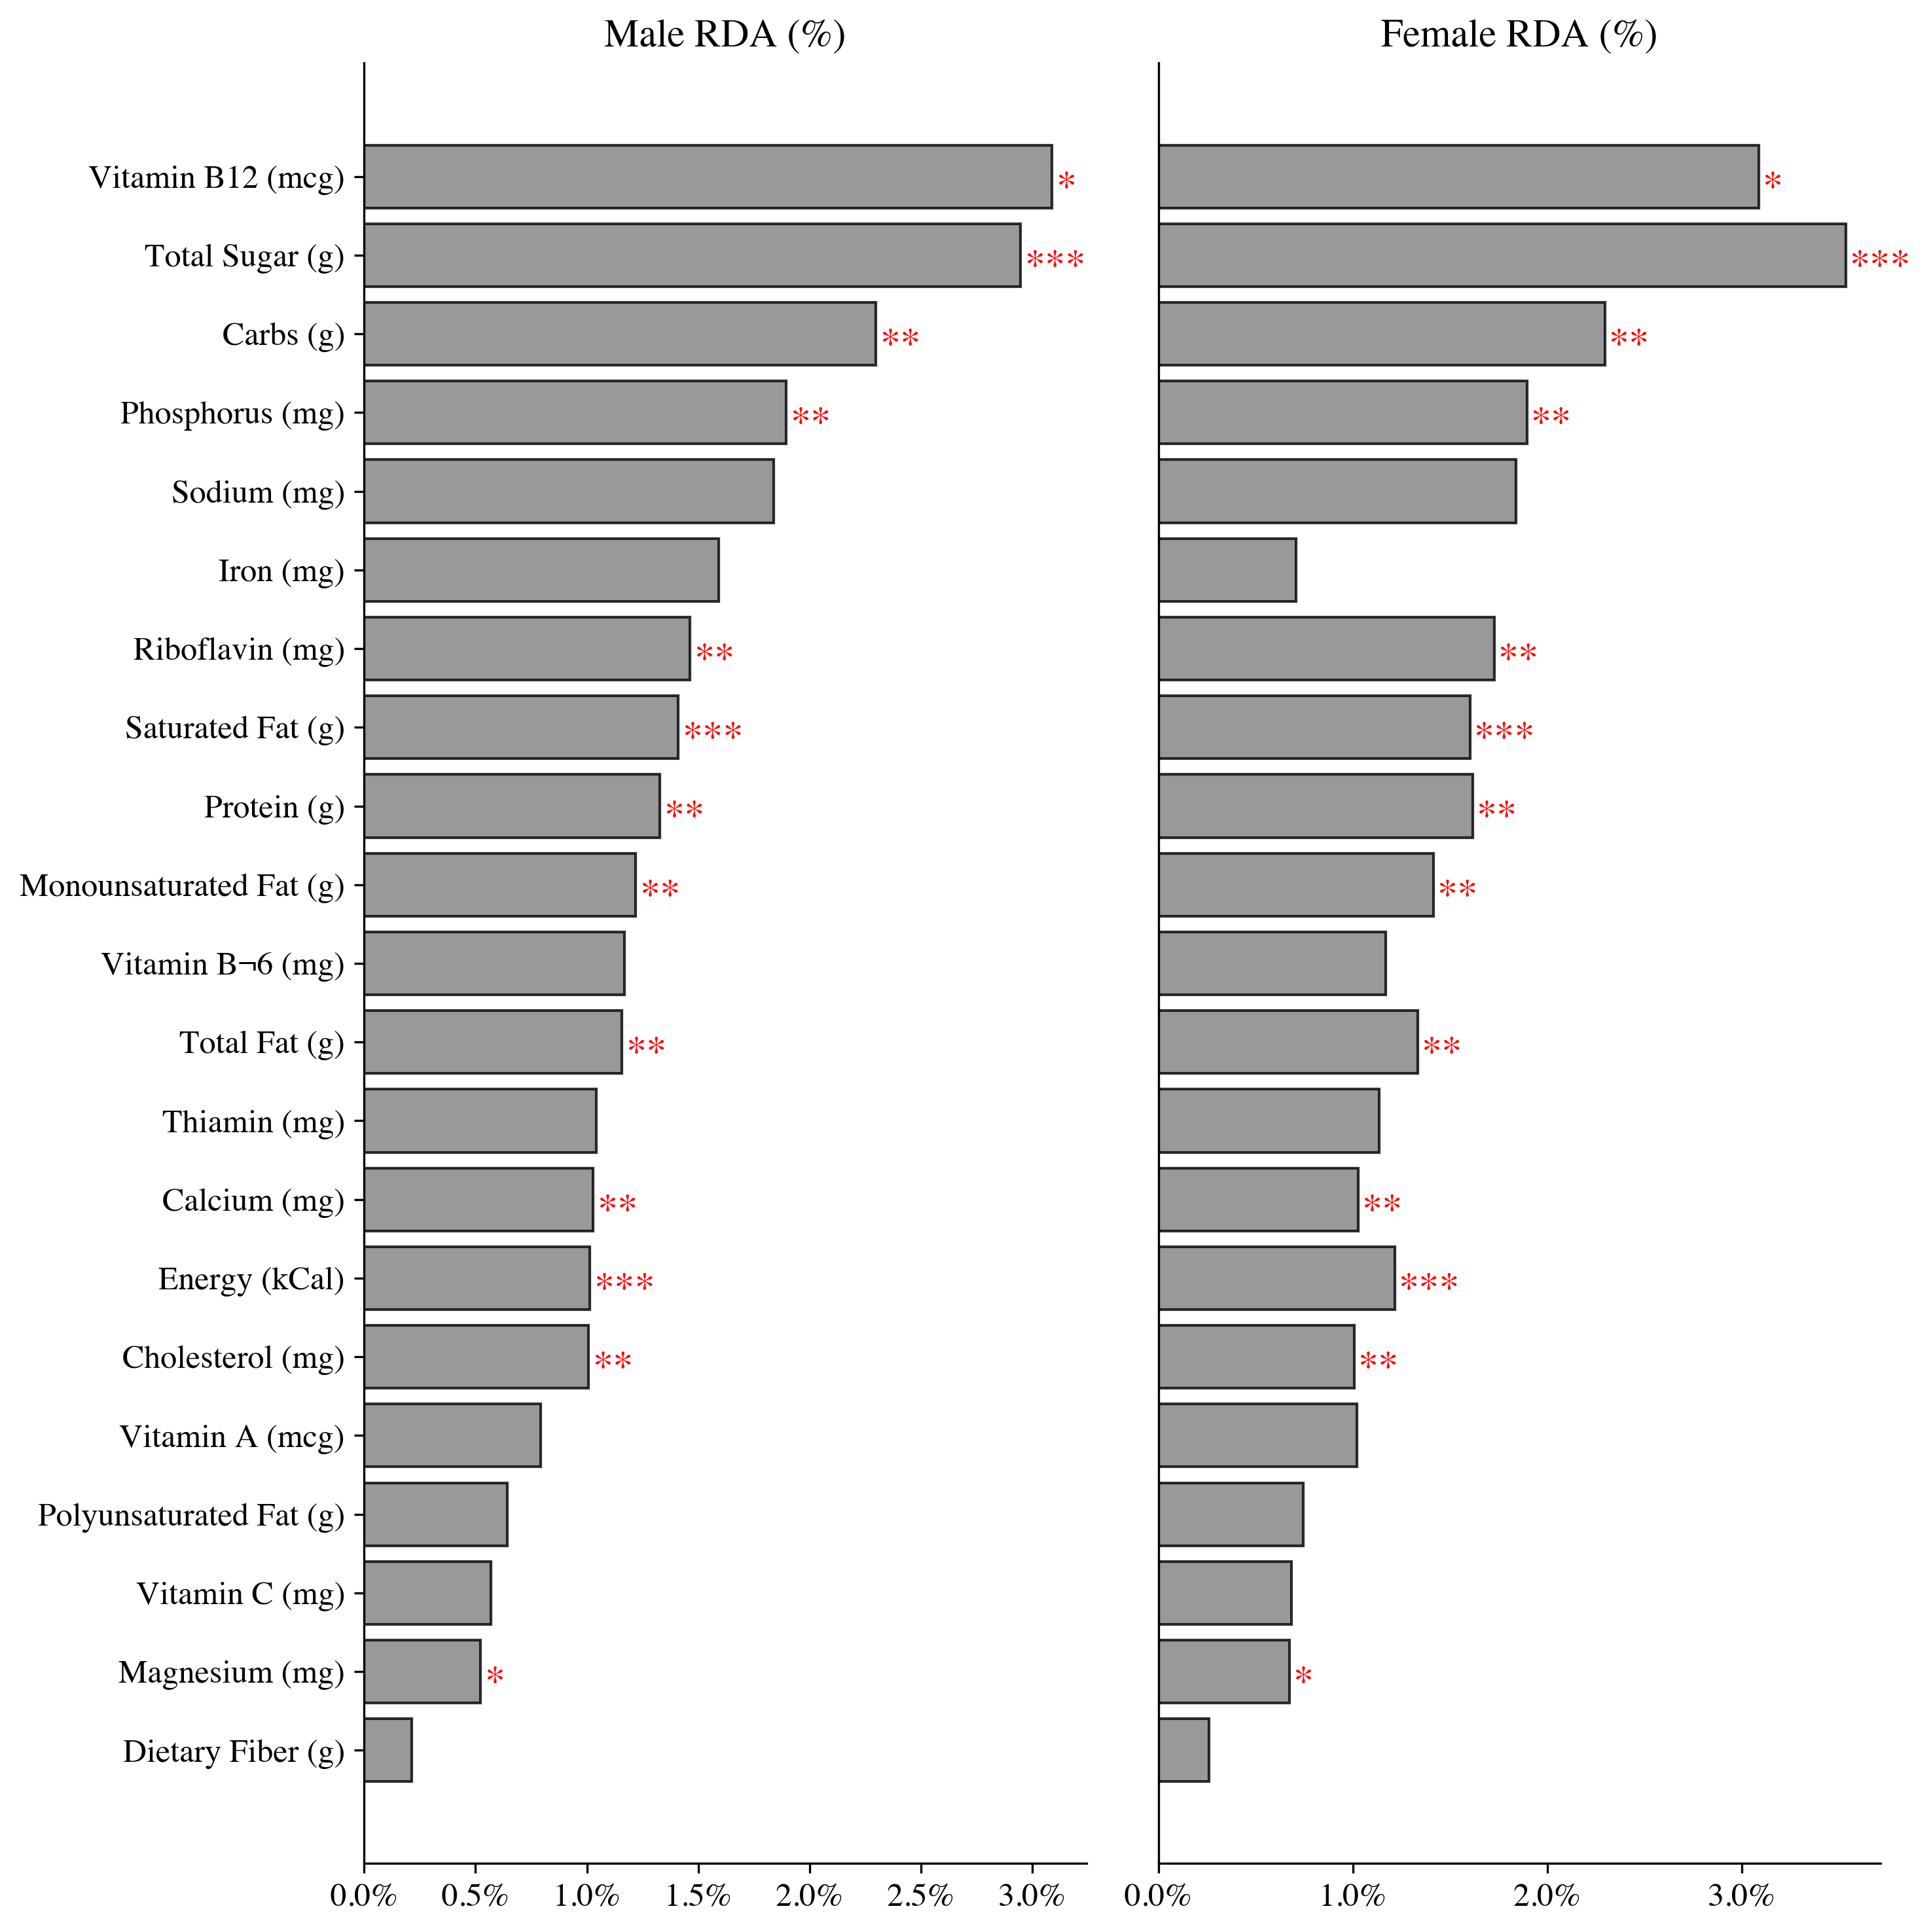

In [353]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times"

import matplotlib.ticker as mtick

## create a figure with two subplots
fig, ax = plt.subplots(1, 2)
male_ax, female_ax = ax[0], ax[1]

## male vertical bar plot
df = df.sort_values("coef_RDA_male")

male_bars = male_ax.barh(df.var_name, df["coef_RDA_male"], 
    color = "grey", alpha = 0.8, edgecolor = "black")

male_ax.set_title("Male RDA (%)")
male_ax.spines[["right", "top"]].set_visible(False)

## mark significant coefficients with *, **, ***
# male_ax.bar_label(male_bars, labels = " " + df["stars"], fontsize = 15, color = "red")
for i, coef in enumerate(df.coef_RDA_male):
    male_ax.text(coef + 0.02, i - 0.17, df.stars.iloc[i],
     va = "center", ha="left", fontsize = 15, color = "red")

## female vertical bar plot
female_ax.barh(df.var_name, df["coef_RDA_female"], 
    color = "grey", alpha = 0.8, edgecolor = "black")

female_ax.spines[["right", "top"]].set_visible(False)
female_ax.set_title("Female RDA (%)")

for i, coef in enumerate(df.coef_RDA_female):
    female_ax.text(coef + 0.02, i - 0.17, df.stars.iloc[i],
     va = "center", ha="left", fontsize = 15, color = "red")

# get rid of of the y-axis ticks for the female_ax
female_ax.set_yticks([])

male_ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
female_ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

plt.tight_layout()

In [281]:
male_error_bars

[20    0.2109
 19    0.8902
 18    0.4848
 17    0.6625
 16    0.2740
 15    0.4533
 14    0.1481
 13    1.1928
 12    0.3551
 11    0.2543
 10    0.1328
 9     0.4442
 8     0.6592
 7     0.1042
 6     0.5729
 5     0.7326
 4     0.5373
 3     1.6490
 2    -0.0084
 1     1.1515
 0     0.5371
 Name: Lower_RDA_male, dtype: float64,
 20   0.8332
 19   2.8984
 18   1.5725
 17   2.2606
 16   1.8093
 15   2.7318
 14   0.9901
 13   4.9822
 12   1.9834
 11   1.3337
 10   3.5444
 9    1.5688
 8    1.9941
 7    1.1801
 6    1.8659
 5    2.0874
 4    1.7773
 3    4.2440
 2    0.4366
 1    3.4438
 0    1.4909
 Name: Upper_RDA_male, dtype: float64]

In [230]:
def mean_ajdusted_by_ame(nutrient_series):
    """
    Returns the mean of a nutrient series, adjusted by the AME.
    """
    return nutrient_series.sum() / nutrient_series.count()

for nutrient in response_vars:
    snap[nutrient+"_adj"] = snap[nutrient] / snap["AME"]

pd.options.display.float_format = "{:,.0f}".format

snap.groupby("targetgroup").agg(
    {"hhnum": "count", 
    "fah_energy_adj": "mean",
    "fah_carb_adj": "mean",
    "fah_dietfiber_adj": "mean",
    "fah_totsug_adj": "mean",
    "fah_totfat_adj": "mean",
    "fah_satfat_adj": "mean",
    "fah_monofat_adj": "mean",
    "fah_polyfat_adj": "mean",
    "fah_protein_adj": "mean",
    "fah_chol_adj": "mean",
    "fah_sodium_adj": "mean",
    "fah_vitarae_adj": "mean",
    "fah_vitb6_adj": "mean",
    "fah_vitb12_adj": "mean",
    "fah_vitc_adj": "mean",
    "fah_iron_adj": "mean",
    "fah_thiamin_adj": "mean",
    "fah_riboflavin_adj": "mean",
    "fah_calcium_adj": "mean",
    "fah_phosphorus_adj": "mean",
    "fah_magnes_adj": "mean"
    }).transpose()
    

targetgroup,1,2,3,4
hhnum,259,707,"1,703","1,268"
fah_energy_adj,"21,200","24,766","23,706","24,546"
fah_carb_adj,"2,872","3,239","3,138","3,259"
fah_dietfiber_adj,165,179,185,157
fah_totsug_adj,"1,387","1,548","1,500","1,627"
fah_totfat_adj,817,"1,025",937,999
fah_satfat_adj,260,322,304,313
fah_monofat_adj,297,359,330,355
fah_polyfat_adj,201,269,233,258
fah_protein_adj,587,706,688,679


In [58]:
sg = Stargazer(restriction_1_res.values())
sg.render_html()

'<table style="text-align:center"><tr><td colspan="22" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="21"><em>Dependent variable:y</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td><td>(7)</td><td>(8)</td><td>(9)</td><td>(10)</td><td>(11)</td><td>(12)</td><td>(13)</td><td>(14)</td><td>(15)</td><td>(16)</td><td>(17)</td><td>(18)</td><td>(19)</td><td>(20)</td><td>(21)</td></tr><tr><td colspan="22" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">black</td><td>-4635.800<sup>**</sup></td><td>-671.115<sup>**</sup></td><td>-42.224<sup>***</sup></td><td>-343.674<sup>**</sup></td><td>-132.589<sup></sup></td><td>-88.646<sup>***</sup></td><td>-34.486<sup></sup></td><td>3.693<sup></sup></td><td>-177.762<sup>***</sup></td><td>-475.466<sup>*</sup></td><td>-10927.456<sup></sup></td><td>-2052.900<sup>***</sup>

In [225]:
for nut in nutrients:
    print(f'"{nut}_adj": "mean",')

"fah_energy_adj": "mean",
"fah_carb_adj": "mean",
"fah_dietfiber_adj": "mean",
"fah_totsug_adj": "mean",
"fah_totfat_adj": "mean",
"fah_satfat_adj": "mean",
"fah_monofat_adj": "mean",
"fah_polyfat_adj": "mean",
"fah_protein_adj": "mean",
"fah_alcohol_adj": "mean",
"fah_chol_adj": "mean",
"fah_sodium_adj": "mean",
"fah_vitarae_adj": "mean",
"fah_vitb6_adj": "mean",
"fah_vitb12_adj": "mean",
"fah_vitc_adj": "mean",
"fah_iron_adj": "mean",
"fah_thiamin_adj": "mean",
"fah_riboflavin_adj": "mean",
"fah_calcium_adj": "mean",
"fah_phosphorus_adj": "mean",
"fah_magnes_adj": "mean",


In [211]:
cnx.close()